In [1]:
%%capture
!pip install git+https://github.com/source-separation/tutorial

In [2]:
# Do our imports
import warnings
warnings.simplefilter('ignore')
import nussl
import matplotlib.pyplot as plt
import numpy as np
import librosa
from common import viz

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


Harmonic-Percussive Source Separation (HPSS)

スペクトログラムで，音楽信号を視覚化していくうちに，
ハーモニックは横縞に，パーカッシブな音は縦縞に似ていることに気づき始める．(らしい)


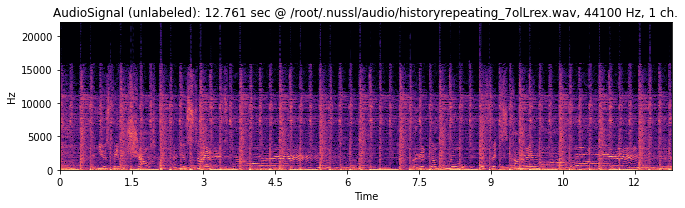

In [3]:
audio_path = nussl.efz_utils.download_audio_file('historyrepeating_7olLrex.wav', verbose=False)
history = nussl.AudioSignal(audio_path)
history.embed_audio()

plt.figure(figsize=(10, 3))
nussl.utils.visualize_spectrogram(history)
plt.title(str(history))
plt.tight_layout()
plt.show()

Harmonic-Percussive Source Separation (HPSS)は，周波数ビン（水平方向，つまりハーモニック）と時間ビン（垂直方向，つまりパーカッシブ）をまたいで

In [4]:
class MyHPSS(nussl.separation.base.MaskSeparationBase):
    
    def __init__(self, audio_signal, kernel_size=31, mask_type='soft',
                 mask_threshold=0.5):
        """Setup code goes here."""
        
        # The super class will save all of these attributes for us.
        super().__init__(
            input_audio_signal=audio_signal, 
            mask_type=mask_type,
            mask_threshold=mask_threshold
        )
        
        # Save the kernel size.
        self.kernel_size = kernel_size
        
    def run(self):
        """Code for running HPSS. Returns masks."""
        
        # Keep a list of each mask type.
        harmonic_masks = []
        percussive_masks = []

        # Our signal might have more than one channel:
        # Apply HPSS to each channel individually.
        for ch in range(self.audio_signal.num_channels):
            # apply mask
            harmonic_mask, percussive_mask = librosa.decompose.hpss(
                self.stft[:, :, ch], kernel_size=self.kernel_size, mask=True)
            harmonic_masks.append(harmonic_mask)
            percussive_masks.append(percussive_mask)

        # Order the masks correctly.
        harmonic_masks = np.stack(harmonic_masks, axis=-1)
        percussive_masks = np.stack(percussive_masks, axis=-1)
        _masks = np.stack([harmonic_masks, percussive_masks], axis=-1)
        
        # Convert the masks to `nussl.MaskBase` types.
        self.result_masks = []
        for i in range(_masks.shape[-1]):
            mask_data = _masks[..., i]
            if self.mask_type == self.MASKS['binary']:
                mask_data = _masks[..., i] == np.max(_masks, axis=-1)
            mask = self.mask_type(mask_data)
            self.result_masks.append(mask)

        # Return the masks>
        return self.result_masks
        

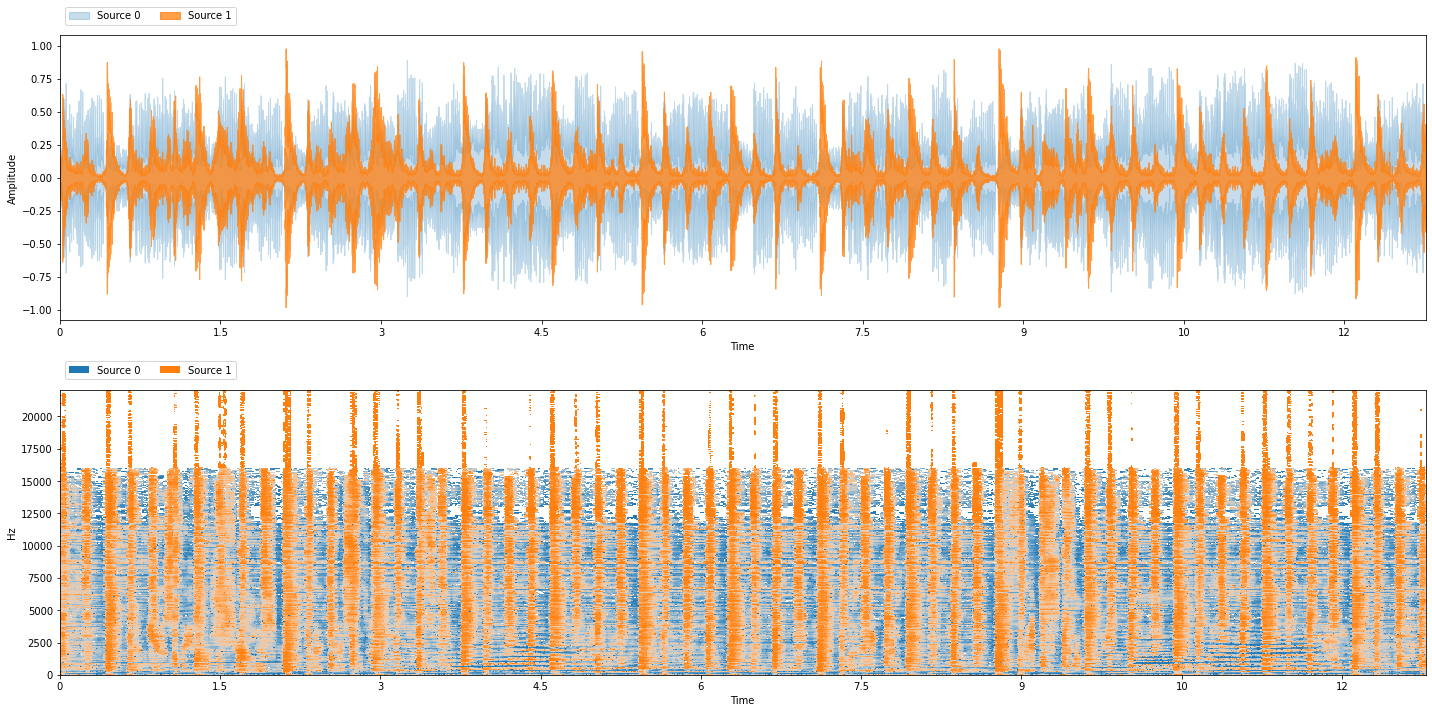


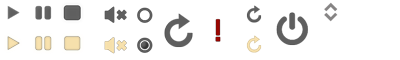
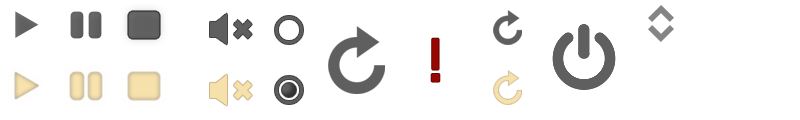
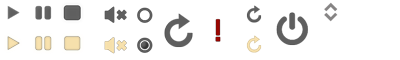

In [5]:
my_hpss = MyHPSS(history)
hpss_estimates = my_hpss()

viz.show_sources(hpss_estimates)

In [6]:
%%capture
# Comment out the line above to run this cell
# interactively in Colab or Jupyter Notebook

my_hpss.interact(share=True, source='microphone')

In [7]:
%%capture
# Comment out the line above to run this cell
# interactively in Colab or Jupyter Notebook

my_hpss.interact(share=True)